In [3]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd.variable import Variable

# Взводим руками рандом сид для воспроизводимости обучения
manualSeed = 333
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  333


In [5]:
# Директория с датасетом покемонов. Внимание!!! Чтобы даталоадер работал, необходимо положить картинки в 
# папку по типу .../pokemon/1/0.png, .../pokemon/1/1.png и т.д. Без этого даталоадер работать не будет
dataroot = "./pokemon/1/"

# Количество воркеров для даталоадера
workers = 1

# Размер батча для обучения
batch_size = 64

# Размер скрытого вектора z
nz = 100

# Кол-во эпох обучения
num_epochs = 1000
dataroot

'./pokemon/1/'

Current device : cuda:0


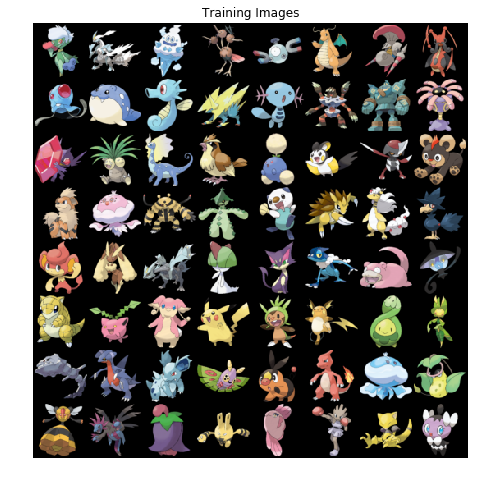

In [6]:
# Создаем даталоадер
image_size=64
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# переключаемся на куду
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Current device : {}".format(device))

# Выведем трейнсет, дабы убедиться, что все завелось
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [20]:
# функция для инициализации весов из статьи про GAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.ConvTranspose2d(100, 1024, 4, 1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.relu = nn.ReLU()
        self.conv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.ConvTranspose2d(512, 256, 4, 2,1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.ConvTranspose2d(128, 3, 4, 2, 1)
        self.tan = nn.Tanh()

    def forward(self, input):
        input = self.relu(self.bn1(self.conv1(input)))
        input = self.relu(self.bn2(self.conv2(input)))
        input = self.relu(self.bn3(self.conv3(input)))
        input = self.relu(self.bn4(self.conv4(input)))
        input = self.tan(self.conv5(input))
        return input


# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.conv1 = nn.ConvTranspose2d(100, 1024, 5, 2, 1)
#         self.bn1 = nn.BatchNorm2d(1024)
#         self.relu = nn.ReLU()
#         self.conv2 = nn.ConvTranspose2d(1024, 512, 5, 2, 2)
#         self.bn2 = nn.BatchNorm2d(512)
#         self.conv3 = nn.ConvTranspose2d(512, 256, 5, 2, 2)
#         self.bn3 = nn.BatchNorm2d(256)
#         self.conv4 = nn.ConvTranspose2d(256, 128, 5, 2, 2)
#         self.bn4 = nn.BatchNorm2d(128)
#         self.conv5 = nn.ConvTranspose2d(128, 3, 5, 2, 2)
#         self.bn5 = nn.BatchNorm2d(3)
#         self.tan = nn.Tanh()

#     def forward(self, input):
#         input = self.relu(self.bn1(self.conv1(input)))
#         input = self.relu(self.bn2(self.conv2(input)))
#         input = self.relu(self.bn3(self.conv3(input)))
#         input = self.relu(self.bn4(self.conv4(input)))
#         input = self.tan(self.bn5(self.conv5(input)))
#         return input

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.layer1 = nn.ConvTranspose2d(100, 1024, 4, 1)
#         self.layer2 = nn.BatchNorm2d(1024)
#         self.layer3 = nn.ReLU()
#         self.layer4 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
#         self.layer5 = nn.BatchNorm2d(512)
#         self.layer6 = nn.ReLU()
#         self.layer7 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
#         self.layer8 = nn.BatchNorm2d(256)
#         self.layer9 = nn.ReLU()
#         self.layer10 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
#         self.layer11 = nn.BatchNorm2d(128)
#         self.layer12 = nn.ReLU()
#         self.layer13 = nn.ConvTranspose2d(128, 3, 4, 2, 1)
#         self.layer14 = nn.Tanh()

#     def forward(self, input):
#         input = self.layer1(input)
#         input = self.layer2(input)
#         input = self.layer3(input)
#         input = self.layer4(input)
#         input = self.layer5(input)
#         input = self.layer6(input)
#         input = self.layer7(input)
#         input = self.layer8(input)
#         input = self.layer9(input)
#         input = self.layer10(input)
#         input = self.layer11(input)
#         input = self.layer12(input)
#         input = self.layer13(input)
#         input = self.layer14(input)
#         return input

In [22]:
# Создали генератор
netG = Generator().to(device)

# Инициализировали его
netG.apply(weights_init)

# Вывели модель для отладки
print(netG)

Generator(
  (conv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tan): Tanh()
)


In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 4, 2,1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(128, 256, 4, 2,1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 4, 2,1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, 4, 2,1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1, 4, 1)
        self.sigmoid= nn.Sigmoid()
        
    def forward(self, input):
        input = self.relu(self.bn1(self.conv1(input)))
        input = self.relu(self.bn2(self.conv2(input)))
        input = self.relu(self.bn3(self.conv3(input)))
        input = self.relu(self.bn4(self.conv4(input)))
        input = self.sigmoid(self.conv5(input))


        return input.view(-1, 1).squeeze(1)




# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.layer1 = nn.Conv2d(3, 128, 4, 2, 1)
#         self.layer2 = nn.LeakyReLU(0.2)
#         self.layer3 = nn.Conv2d(128, 256, 4, 2, 1)
#         self.layer4 = nn.BatchNorm2d(256)
#         self.layer5 = nn.LeakyReLU(0.2)
#         self.layer6 = nn.Conv2d(256, 512, 4, 2, 1)
#         self.layer7 = nn.BatchNorm2d(512)
#         self.layer8 = nn.LeakyReLU(0.2)
#         self.layer9 = nn.Conv2d(512, 1024, 4, 2, 1)
#         self.layer10 = nn.BatchNorm2d(1024)
#         self.layer11 = nn.LeakyReLU(0.2)
#         self.layer12 = nn.Conv2d(1024, 1, 4, 1)
#         self.layer13 = nn.Sigmoid()
        
#     def forward(self, input):
#         input = self.layer1(input)
#         input = self.layer2(input)
#         input = self.layer3(input)
#         input = self.layer4(input)
#         input = self.layer5(input)
#         input = self.layer6(input)
#         input = self.layer7(input)
#         input = self.layer8(input)
#         input = self.layer9(input)
#         input = self.layer10(input)
#         input = self.layer11(input)
#         input = self.layer12(input)
#         input = self.layer13(input)

#         return input.view(-1, 1).squeeze(1)


In [24]:
# Создали дискриминатор
netD = Discriminator().to(device)

# Ининциализировали весе
netD.apply(weights_init)

# Вывели модель для отладки
print(netD)

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
  (sigmoid): Sigmoid()
)


In [25]:
# Фиксированный шум для мониторинга качества генерации
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Коэффициент обучения
lr = 0.00005

# Оптимизаторы для сеток
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)



In [26]:
def D_loss(D_real,D_fake):
    loss = -(torch.mean(D_real) - torch.mean(D_fake))
    return loss



In [27]:
def G_loss(D_fake):
    loss = -torch.mean(D_fake)
    return loss

In [28]:
# код для обучения дискриминатора
def D_loss(D_real,D_fake):
    loss = -(torch.mean(D_real) - torch.mean(D_fake))
    return loss



def train_D(discriminator, images, fake_images):
#             optimizerD.zero_grad()
        discriminator.zero_grad()
        # forward + backward + optimize
        outputs = discriminator(images)
        fake_images=discriminator(fake_images)
        loss = D_loss(outputs, fake_images)
        loss.backward()
        optimizerD.step()
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)


        return loss, outputs, fake_images

In [29]:
# код для обучения генератора
def train_G(generator, discriminator, fake_images):
#             optimizerG.zero_grad()
    generator.zero_grad()
    outputs = generator(fake_images)
    fake_image=discriminator(outputs)
    loss = G_loss(fake_image)
    loss.backward()
    optimizerG.step()

    return loss

In [30]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

d_episodes = 1

print("Starting Training Loop...")
for epoch in range(num_epochs):

    data_iter = iter(dataloader)
    i = 0
    
    while i < len(dataloader):
        image = next(data_iter)[0].to(device)
        image = Variable(image)
        # Train the discriminator
        for _ in range(5):
            noise = Variable(torch.randn(64, 100, 1, 1)).to(device)
            fake_images = netG(noise).to(device)
            d_loss, real_score, fake_score = train_D(netD, image, fake_images)

        # Train the generator
        noise = Variable(torch.randn(64, 100, 1, 1)).to(device)
        g_loss = train_G(netG,netD, noise)
        
        # обучаем дискриминатор
        # d_loss = wasserstein loss дискриминатора
        # real_score - оценки дискриминатора для настоящих картинок
        # fake_score - оценки дискриминатора для фейковых картинок
        # помните, что на одну итерацию обучения генератора
        # должно приходиться несколько итераций обучения дискриминатора!
        
        # обучаем генератор
        # g_loss = critic-loss генератора
        i += 1
        # Выводим стату
        if i % 1 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Сохраняем результат генерации для нашего фиксированного шума( для валидации )
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/1000][1/13]	Loss_D: -0.0459	Loss_G: -0.4775	D(x): 0.5268	D(G(z)): 0.4809
[0/1000][2/13]	Loss_D: -0.0332	Loss_G: -0.4914	D(x): 0.5303	D(G(z)): 0.4970
[0/1000][3/13]	Loss_D: -0.0359	Loss_G: -0.4930	D(x): 0.5352	D(G(z)): 0.4993
[0/1000][4/13]	Loss_D: -0.0428	Loss_G: -0.4863	D(x): 0.5364	D(G(z)): 0.4935
[0/1000][5/13]	Loss_D: -0.0608	Loss_G: -0.4694	D(x): 0.5400	D(G(z)): 0.4792
[0/1000][6/13]	Loss_D: -0.0700	Loss_G: -0.4444	D(x): 0.5569	D(G(z)): 0.4869
[0/1000][7/13]	Loss_D: -0.1110	Loss_G: -0.4497	D(x): 0.5497	D(G(z)): 0.4387
[0/1000][8/13]	Loss_D: -0.1313	Loss_G: -0.4053	D(x): 0.5727	D(G(z)): 0.4414
[0/1000][9/13]	Loss_D: -0.1231	Loss_G: -0.4850	D(x): 0.5198	D(G(z)): 0.3967
[0/1000][10/13]	Loss_D: -0.1331	Loss_G: -0.4110	D(x): 0.5084	D(G(z)): 0.3753
[0/1000][11/13]	Loss_D: -0.1225	Loss_G: -0.3576	D(x): 0.5977	D(G(z)): 0.4752
[0/1000][12/13]	Loss_D: -0.2042	Loss_G: -0.3486	D(x): 0.6140	D(G(z)): 0.4098
[0/1000][13/13]	Loss_D: -0.2278	Loss_G: -0.3384	D(x): 0.625

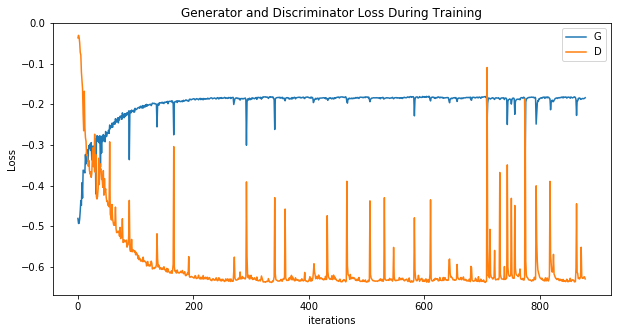

In [19]:
# Выводим на печать всяческие loss'ы
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Проигрываем результаты генерации для фиксированного шума
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

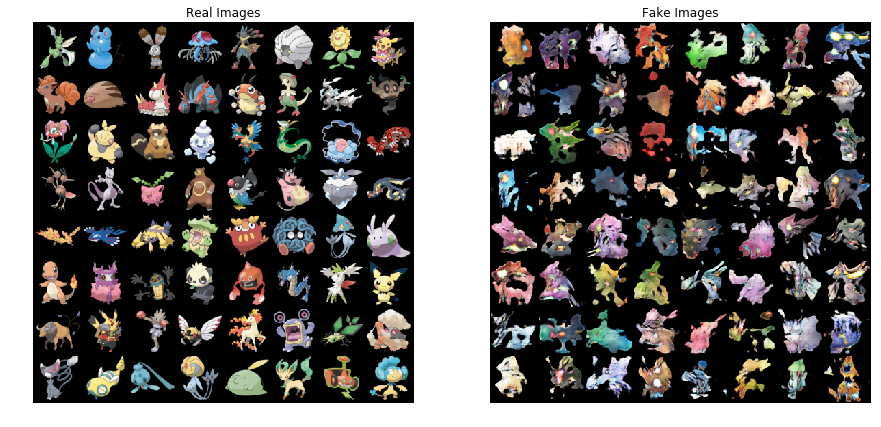

In [31]:
# Сравниваем настоящие данные и генерацию
real_batch = next(iter(dataloader))

# Рисуем трейнсет
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Рисуем фейки
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()